In [1]:
import pandas as pd
import numpy as np

### Loading Dataset

In [2]:
data = pd.read_csv('bank_marketing.csv')

In [3]:
data.shape

(45211, 17)

In [4]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
df_pivot = pd.DataFrame({'types': data.dtypes,
                         'nulls': data.isna().sum(),
                          '% nulls': data.isna().sum() / data.shape[0],
                          'size': data.shape[0],
                          'uniques': data.nunique()})
df_pivot

,types,nulls,% nulls,size,uniques
age,int64,0,0.0,45211,77
job,object,0,0.0,45211,12
marital,object,0,0.0,45211,3
education,object,0,0.0,45211,4
default,object,0,0.0,45211,2
balance,int64,0,0.0,45211,7168
housing,object,0,0.0,45211,2
loan,object,0,0.0,45211,2
contact,object,0,0.0,45211,3
day,int64,0,0.0,45211,31


### Converting categorical to numerical features

In [6]:
import category_encoders as ce
encoder = ce.BinaryEncoder()
df_binary = encoder.fit_transform(data.loc[:,['job','marital', 'education',
                                              'default', 'housing', 'loan',
                                              'contact','month','poutcome']])
df_binary.head()

ModuleNotFoundError: No module named 'category_encoders'

In [ ]:
int_columns = data.select_dtypes(include=['int'])
int_columns = int_columns.columns.values
columns = np.append(int_columns, 'deposit')
columns

array(['age', 'balance', 'day', 'duration', 'campaign', 'pdays',
       'previous', 'deposit'], dtype=object)

In [ ]:
data = pd.concat([df_binary, data.loc[:,columns]], axis=1)
data.head()

,job_0,job_1,job_2,job_3,job_4,marital_0,marital_1,marital_2,education_0,education_1,...,poutcome_1,poutcome_2,age,balance,day,duration,campaign,pdays,previous,deposit
0,0,0,0,0,1,0,0,1,0,0,...,0,1,59,2343,5,1042,1,-1,0,yes
1,0,0,0,0,1,0,0,1,0,0,...,0,1,56,45,5,1467,1,-1,0,yes
2,0,0,0,1,0,0,0,1,0,0,...,0,1,41,1270,5,1389,1,-1,0,yes
3,0,0,0,1,1,0,0,1,0,0,...,0,1,55,2476,5,579,1,-1,0,yes
4,0,0,0,0,1,0,0,1,0,1,...,0,1,54,184,5,673,2,-1,0,yes


### Split Train & Test

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data.loc[:,'job_0':'previous'], 
                                                    data.loc[:,'deposit'], test_size=0.2)

### Normalization

In [ ]:
from sklearn import preprocessing
preprocessParams = preprocessing.StandardScaler().fit(x_train)

In [ ]:
X_train_normalized = preprocessParams.transform(x_train)
X_test_normalized = preprocessParams.transform(x_test)

### Training Neural Network

In [ ]:
from keras import Sequential
from keras.layers import Dense

In [ ]:
RN = Sequential()
RN.add(Dense(22,input_shape = X_train_normalized.shape[1:], activation = 'sigmoid'))
RN.add(Dense(10, activation = 'sigmoid'))
RN.add(Dense(2,activation = 'sigmoid'))
RN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 22)                792       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                230       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 22        
Total params: 1,044
Trainable params: 1,044
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Dummy Transformation
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown = 'ignore')
encoder.fit(pd.DataFrame(y_train))

y_train = encoder.transform(pd.DataFrame(y_train)).toarray()
y_test = encoder.transform(pd.DataFrame(y_test)).toarray()
y_train

array([[0., 1., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 1., 1., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 0., 1.]])

In [ ]:
RN.compile(optimizer = 'sgd', loss = 'mean_squared_error', metrics = ['accuracy'])
history = RN.fit(X_train_normalized,y_train, epochs = 125, validation_split=0.2) 

Epoch 1/125
224/224 [==============================] - 0s 2ms/step - loss: 0.2712 - accuracy: 0.4672 - val_loss: 0.2595 - val_accuracy: 0.4944
Epoch 2/125
224/224 [==============================] - 0s 2ms/step - loss: 0.2584 - accuracy: 0.4676 - val_loss: 0.2529 - val_accuracy: 0.4933
Epoch 3/125
224/224 [==============================] - 0s 2ms/step - loss: 0.2525 - accuracy: 0.4864 - val_loss: 0.2504 - val_accuracy: 0.4966
Epoch 4/125
224/224 [==============================] - 0s 2ms/step - loss: 0.2500 - accuracy: 0.5174 - val_loss: 0.2495 - val_accuracy: 0.5314
Epoch 5/125
224/224 [==============================] - 0s 2ms/step - loss: 0.2487 - accuracy: 0.5393 - val_loss: 0.2491 - val_accuracy: 0.5190
Epoch 6/125
224/224 [==============================] - 0s 2ms/step - loss: 0.2480 - accuracy: 0.5394 - val_loss: 0.2488 - val_accuracy: 0.5168
Epoch 7/125
224/224 [==============================] - 0s 2ms/step - loss: 0.2475 - accuracy: 0.5412 - val_loss: 0.2485 - val_accuracy: 0.5123

Epoch 58/125
224/224 [==============================] - 0s 2ms/step - loss: 0.1976 - accuracy: 0.7361 - val_loss: 0.1985 - val_accuracy: 0.7307
Epoch 59/125
224/224 [==============================] - 0s 2ms/step - loss: 0.1960 - accuracy: 0.7383 - val_loss: 0.1971 - val_accuracy: 0.7318
Epoch 60/125
224/224 [==============================] - 0s 2ms/step - loss: 0.1945 - accuracy: 0.7399 - val_loss: 0.1956 - val_accuracy: 0.7363
Epoch 61/125
224/224 [==============================] - 0s 2ms/step - loss: 0.1930 - accuracy: 0.7409 - val_loss: 0.1941 - val_accuracy: 0.7391
Epoch 62/125
224/224 [==============================] - 0s 2ms/step - loss: 0.1915 - accuracy: 0.7435 - val_loss: 0.1927 - val_accuracy: 0.7436
Epoch 63/125
224/224 [==============================] - 0s 2ms/step - loss: 0.1900 - accuracy: 0.7456 - val_loss: 0.1912 - val_accuracy: 0.7441
Epoch 64/125
224/224 [==============================] - 0s 2ms/step - loss: 0.1885 - accuracy: 0.7479 - val_loss: 0.1898 - val_accuracy:

Epoch 115/125
224/224 [==============================] - 0s 2ms/step - loss: 0.1436 - accuracy: 0.8041 - val_loss: 0.1466 - val_accuracy: 0.8040
Epoch 116/125
224/224 [==============================] - 0s 2ms/step - loss: 0.1433 - accuracy: 0.8033 - val_loss: 0.1463 - val_accuracy: 0.8035
Epoch 117/125
224/224 [==============================] - 0s 2ms/step - loss: 0.1430 - accuracy: 0.8027 - val_loss: 0.1460 - val_accuracy: 0.8029
Epoch 118/125
224/224 [==============================] - 0s 2ms/step - loss: 0.1427 - accuracy: 0.8036 - val_loss: 0.1456 - val_accuracy: 0.8035
Epoch 119/125
224/224 [==============================] - 0s 2ms/step - loss: 0.1424 - accuracy: 0.8039 - val_loss: 0.1453 - val_accuracy: 0.8052
Epoch 120/125
224/224 [==============================] - 0s 2ms/step - loss: 0.1421 - accuracy: 0.8046 - val_loss: 0.1451 - val_accuracy: 0.8052
Epoch 121/125
224/224 [==============================] - 0s 2ms/step - loss: 0.1419 - accuracy: 0.8046 - val_loss: 0.1448 - val_ac

In [ ]:
score = RN.evaluate(X_test_normalized, y_test, verbose = 0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.13109786808490753
Test accuracy: 0.823107898235321


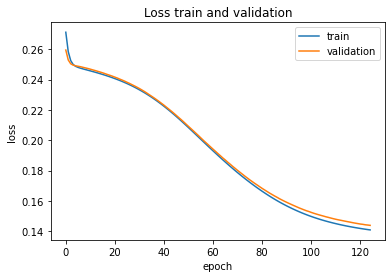

In [ ]:
# Graph training: cost train and validation
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss train and validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend();

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
y_test_predicted = RN.predict(X_test_normalized)
y_test_predicted_indexes = np.argmax(y_test_predicted,axis=1)
y_test_indexes = np.argmax(y_test, axis=1)

In [ ]:
#Confusion Matrix
confMatrix = pd.DataFrame(confusion_matrix(y_test_predicted_indexes, y_test_indexes),
                           index=['0 - No','1 - Yes'],columns=['0 - No','1 - Yes'])

confMatrix.index.name = 'Actual'
confMatrix.columns.name= 'Predicted'
print(confMatrix)

Predicted  0 - No  1 - Yes
Actual                    
0 - No        980      211
1 - Yes       184      858
